# Test 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem


In [2]:
l = 3               # m length of the cubic room
b = 3
h = 2.5
Va = l*b*h   
Sc = Si = 2*l*b+2*b*h+2*l*h  # m² surface of concrete & insulation of the 5 walls

In [3]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


In [4]:
wall = {'Conductivity': [1.4, 0.027],  # W/(m·K)
        'Density': [2300, 55],        # kg/m³
        'Specific heat': [880, 1210],  # J/(kg·K)
        'Width': [0.2, 0.08],
        'Surface': [Sc, Si],  # m²
        'Slices': [1, 1]}                # number of  slices
wall = pd.DataFrame(wall, index=['Concrete', 'Insulation'])
wall

,Conductivity,Density,Specific heat,Width,Surface,Slices
Concrete,1.400,2300,880,0.20,48.0,1
Insulation,0.027,55,1210,0.08,48.0,1


In [5]:
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
α_wSW = 0.25    # short wave absortivity: white smooth surface

In [6]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

In [7]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
h

,in,out
h,8.0,25


In [8]:
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

,Conductance
Concrete,336.0
Insulation,16.2


In [9]:
# Convection
Gw = h * wall['Surface'][0]     # wall

In [10]:
#Tm = 20 + 273   # K, mean temp for radiative exchange
#GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Insulation']
#GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation']

In [11]:
#GLW = 1 / (1 / GLW1)

In [12]:
C_wall = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
C_air = air['Density'] * air['Specific heat'] * Va

In [13]:
pd.DataFrame(C_wall, columns={'Capacity'})

,Capacity
Concrete,19430400.0
Insulation,255552.0


In [14]:
# number of temperature nodes and flow branches
no_θ = no_q = sum(wall['Slices']) + 2
print(no_q)

R_cd = wall['Width'] / (wall['Conductivity'] * Sc)  # K/W
R_cv = 1 / (h * Sc)     # K/W

4


In [15]:
# Conductance matrix
R = np.zeros([no_q])
R[0] = R_cv['out'] 
R[1] = R_cd['Concrete'] 
for i in range(0, wall.Slices['Concrete']+1):
    R[i + 2] =  2*R_cd['Concrete']/(2*(wall.Slices['Concrete'])) 
    if i == wall.Slices['Concrete']:
        R[i+2] = R_cd['Concrete']/(2*(wall.Slices['Concrete'])) + R_cd['Insulation'] / (2*(wall.Slices['Insulation']))
#for j in range(0, wall.Slices['Insulation']+1): 
#    R[j+2+i] =  2*R_cd['Insulation']/(2*(wall.Slices['Insulation'])) 
#    if j == wall.Slices['Insulation']:
#        R[j+2] = R_cd['Insulation']/(2*(wall.Slices['Insulation'])) + R_cv['in']
G = np.diag(np.reciprocal(R))

In [16]:
C = np.zeros(no_θ)
C[0] = 0
for i in range(0, wall.Slices['Concrete']+1):
    C[i+1] = C_wall.Concrete / ((wall.Slices['Concrete']))
for j in range(0, wall.Slices['Insulation']+1):
    C[j+i+1] = C_wall.Insulation / wall.Slices['Insulation']
    if j == wall.Slices['Insulation']:
        C[j+i+1] = C_air
C = np.diag(C)

In [17]:
A = np.eye(no_q, no_θ + 1)
A = -np.diff(A, n=1, axis=1)
pd.DataFrame(A)

,0,1,2,3
0,1.0,-0.0,-0.0,-0.0
1,-1.0,1.0,-0.0,-0.0
2,-0.0,-1.0,1.0,-0.0
3,-0.0,-0.0,-1.0,1.0


In [18]:
b = np.zeros(no_q)
f = np.zeros(no_θ)
print(b)

[0. 0. 0. 0.]


In [19]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [0. 0. 0. 0.] °C


## Steady Stade

In [20]:
b[0] = 1
θ_steady_To = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
np.set_printoptions(precision=3)
print('When To = 1°C, the temperatures in steady-state are:', θ_steady_To, '°C')
print(f'The indoor temperature is: {θ_steady_To[-1]:.3f} °C')

When To = 1°C, the temperatures in steady-state are: [1. 1. 1. 1.] °C
The indoor temperature is: 1.000 °C


In [21]:
b[0] = 0
f[-1] = 1
θ_steady_Qh = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('When Qh = 1W, the temperatures in steady-state are:', θ_steady_Qh, '°C')
print(f'The indoor temperature is: {θ_steady_Qh[-1]:.3f} °C')

When Qh = 1W, the temperatures in steady-state are: [0.001 0.004 0.007 0.039] °C
The indoor temperature is: 0.039 °C


## State-space representation


In [22]:
# State matrix
b = np.zeros(no_q)
f = np.zeros(no_θ)
b[1] = 1
f[1] = 1
print(b)

y = np.zeros(no_q)         # nodes
y[no_q-1] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')
print(f)
print(b)

[0. 1. 0. 0.]
y =  [0. 0. 0. 1.]
As = 
 [[-3.080e-05  1.729e-05  0.000e+00]
 [ 1.315e-03 -1.436e-03  1.210e-04]
 [ 0.000e+00  1.145e-03 -1.145e-03]] 

Bs = 
 [[1.351e-05 5.147e-08]
 [0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00]] 

Cs = 
 [[0. 0. 1.]] 

Ds = 
 [[0. 0.]] 

[0. 1. 0. 0.]
[0. 1. 0. 0.]


In [23]:
b = np.zeros(1)
b[0] = 10
f = np.zeros(1)



In [24]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = min(-2. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [75110.385   588.526  1112.489] s 

2 x Time constants: 
 [150220.771   1177.051   2224.979] s 

Maximum time step: 1177.05 s = 19.62 min


In [25]:
dt = 540     # seconds
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 540 s = 9 min


In [26]:
t_resp = 4 * max(-1 / λ)
print('Time constants: \n', -1 / λ, 's \n')
print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
= {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

Time constants: 
 [75110.385   588.526  1112.489] s 

Settling time: 300442 s = 5007.4 min = 83.46 h = 3.48 days


## Step Response


In [27]:
duration = 300442            # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
pd.DataFrame(t, columns=['time'])
print(n)

Duration = 300442 s
Number of time steps = 556
556


In [28]:
u = np.zeros([2, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0, :] = 10 * np.ones([1, n])    # To = 10 for n time steps
u[1, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
print('u = ')
pd.DataFrame(u)

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

u = 
yss = [[10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076 10.076
  10.076 10.076 10.076 10.076 10.076 10.076 10.076 10

In [29]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

In [30]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u



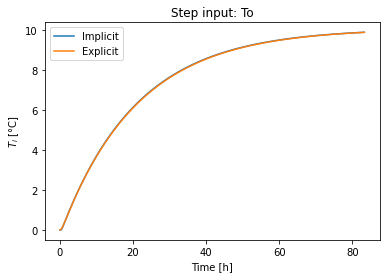

In [31]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To')
ax.legend(['Implicit', 'Explicit'])
plt.show()

### 

In [32]:
start_date = '2000-01-03 12:00:00'
end_date = '2000-02-05 18:00:00'

print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date


In [33]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

In [34]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(
    weather.index >= start_date) & (
    weather.index < end_date)]

pd.DataFrame(weather)

,temp_air,dir_n_rad,dif_h_rad
2000-01-03 12:00:00+01:00,6.8,6,133
2000-01-03 13:00:00+01:00,8.0,74,150
2000-01-03 14:00:00+01:00,10.0,90,135
2000-01-03 15:00:00+01:00,9.0,64,84
2000-01-03 16:00:00+01:00,8.0,0,19
...,...,...,...
2000-02-05 13:00:00+01:00,11.0,696,99
2000-02-05 14:00:00+01:00,12.0,540,126
2000-02-05 15:00:00+01:00,12.0,383,109
2000-02-05 16:00:00+01:00,11.0,136,79


In [35]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
pd.DataFrame(rad_surf)

,direct,diffuse,reflected
2000-01-03 12:00:00+01:00,5.423683,66.5,27.025936
2000-01-03 13:00:00+01:00,62.074669,75.0,34.289730
2000-01-03 14:00:00+01:00,66.175859,67.5,30.353167
2000-01-03 15:00:00+01:00,38.420856,42.0,17.456968
2000-01-03 16:00:00+01:00,0.000000,9.5,3.800000
...,...,...,...
2000-02-05 13:00:00+01:00,547.837791,49.5,73.778661
2000-02-05 14:00:00+01:00,366.835007,63.0,55.437685
2000-02-05 15:00:00+01:00,206.374750,54.5,32.485083
2000-02-05 16:00:00+01:00,51.032277,39.5,15.800272


In [36]:
rad_surf['Etot'] = rad_surf.sum(axis=1)

In [37]:
data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
pd.DataFrame(data)

,To,Etot
2000-01-03 12:00:00+01:00,6.80,98.949619
2000-01-03 12:09:00+01:00,6.91,98.896029
2000-01-03 12:18:00+01:00,7.02,98.842440
2000-01-03 12:27:00+01:00,7.13,98.788850
2000-01-03 12:36:00+01:00,7.24,98.735260
...,...,...
2000-02-05 16:21:00+01:00,12.00,293.359833
2000-02-05 16:30:00+01:00,12.00,293.359833
2000-02-05 16:39:00+01:00,12.00,293.359833
2000-02-05 16:48:00+01:00,12.00,293.359833


In [38]:
weather['temp_air']

2000-01-03 12:00:00+01:00     6.8
2000-01-03 13:00:00+01:00     8.0
2000-01-03 14:00:00+01:00    10.0
2000-01-03 15:00:00+01:00     9.0
2000-01-03 16:00:00+01:00     8.0
                             ... 
2000-02-05 13:00:00+01:00    11.0
2000-02-05 14:00:00+01:00    12.0
2000-02-05 15:00:00+01:00    12.0
2000-02-05 16:00:00+01:00    11.0
2000-02-05 17:00:00+01:00    10.0
Name: temp_air, Length: 798, dtype: float64

In [39]:
data['Ti'] = 20 * np.ones(data.shape[0])
pd.DataFrame(data)

,To,Etot,Ti
2000-01-03 12:00:00+01:00,6.80,98.949619,20.0
2000-01-03 12:09:00+01:00,6.91,98.896029,20.0
2000-01-03 12:18:00+01:00,7.02,98.842440,20.0
2000-01-03 12:27:00+01:00,7.13,98.788850,20.0
2000-01-03 12:36:00+01:00,7.24,98.735260,20.0
...,...,...,...
2000-02-05 16:21:00+01:00,12.00,293.359833,20.0
2000-02-05 16:30:00+01:00,12.00,293.359833,20.0
2000-02-05 16:39:00+01:00,12.00,293.359833,20.0
2000-02-05 16:48:00+01:00,12.00,293.359833,20.0


In [40]:
To = data['To']
Ti = data['Ti']
Φo = α_wSW * wall['Surface']['Concrete'] * data['Etot']

u = pd.concat([To, Φo], axis=1)
pd.DataFrame(u)
print(u)

                              To         Etot
2000-01-03 12:00:00+01:00   6.80  1187.395429
2000-01-03 12:09:00+01:00   6.91  1186.752352
2000-01-03 12:18:00+01:00   7.02  1186.109275
2000-01-03 12:27:00+01:00   7.13  1185.466198
2000-01-03 12:36:00+01:00   7.24  1184.823121
...                          ...          ...
2000-02-05 16:21:00+01:00  12.00  3520.317993
2000-02-05 16:30:00+01:00  12.00  3520.317993
2000-02-05 16:39:00+01:00  12.00  3520.317993
2000-02-05 16:48:00+01:00  12.00  3520.317993
2000-02-05 16:57:00+01:00  12.00  3520.317993

[5314 rows x 2 columns]


In [41]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

In [42]:
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

In [44]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T

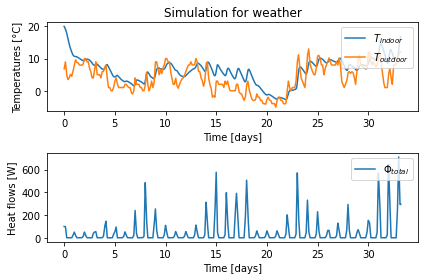

In [45]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [days]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Etot'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()